# Imports

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow:", tf.__version__)

TensorFlow: 2.19.0


# DataSet

In [2]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv"
df_raw = pd.read_csv(url, header=0, names=["Month", "Sales"])

df_raw["Month"] = pd.to_datetime(df_raw["Month"], format="%m-%y")
df_raw = df_raw.sort_values("Month").reset_index(drop=True)

df_raw.head()

,Month,Sales
0,2001-01-01,266.0
1,2001-02-01,194.3
2,2001-03-01,339.7
3,2002-01-01,145.9
4,2002-02-01,149.5


# Visualización serie de tiempo

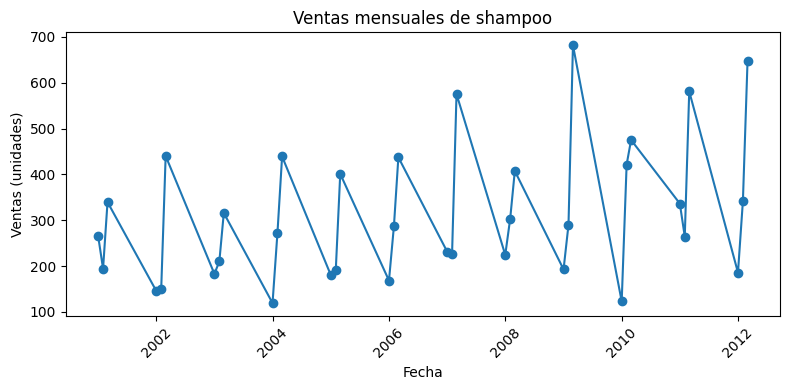

In [3]:
plt.figure(figsize=(8,4))
plt.plot(df_raw["Month"], df_raw["Sales"], marker="o")
plt.xlabel("Fecha")
plt.ylabel("Ventas (unidades)")
plt.title("Ventas mensuales de shampoo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Preparación de la serie

In [4]:
serie_ventas = df_raw["Sales"].values.reshape(-1, 1)

scaler = MinMaxScaler()
ventas_escaladas = scaler.fit_transform(serie_ventas)

window_size = 12

def crear_secuencias(valores, window_size):
    X, y = [], []
    for i in range(len(valores) - window_size):
        X.append(valores[i:i+window_size])
        y.append(valores[i+window_size])
    return np.array(X), np.array(y)

X, y = crear_secuencias(ventas_escaladas, window_size)
print("Forma X:", X.shape)   # (muestras, window_size, 1)
print("Forma y:", y.shape)

Forma X: (24, 12, 1)
Forma y: (24, 1)


# Separar entrenamiento y prueba

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

num_features = X_train.shape[2]

Train: (19, 12, 1) (19, 1)
Test : (5, 12, 1) (5, 1)


# Modelo LSTM

In [6]:
tf.random.set_seed(42)

model = keras.Sequential([
    layers.Input(shape=(window_size, num_features)),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(32, return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    run_eagerly=True
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,913 (120.75 KB)

 Trainable params: 30,913 (120.75 KB)

 Non-trainable params: 0 (0.00 B)

# Entrenamiento del modelo

In [7]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

hist = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=80,
    batch_size=8,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - loss: 0.1813 - val_loss: 0.1662
Epoch 2/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 878ms/step - loss: 0.1529 - val_loss: 0.1337
Epoch 3/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step - loss: 0.1245 - val_loss: 0.1010
Epoch 4/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 452ms/step - loss: 0.1045 - val_loss: 0.0721
Epoch 5/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step - loss: 0.0876 - val_loss: 0.0552
Epoch 6/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step - loss: 0.0616 - val_loss: 0.0592
Epoch 7/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 419ms/step - loss: 0.0563 - val_loss: 0.0737
Epoch 8/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step - loss: 0.0732 - val_loss: 0.0711
Epoch 9/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step - loss: 0.0699 - val_loss: 0.0603
Epoch 10/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 409ms/step - loss: 0.0598 - val_loss: 0.0546
Epoch 11/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 415ms/step - loss: 0.0547 - val_loss: 0.0545
Epoch 12/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step - loss: 0.0572 - val_loss:

# Curvas de pérdida

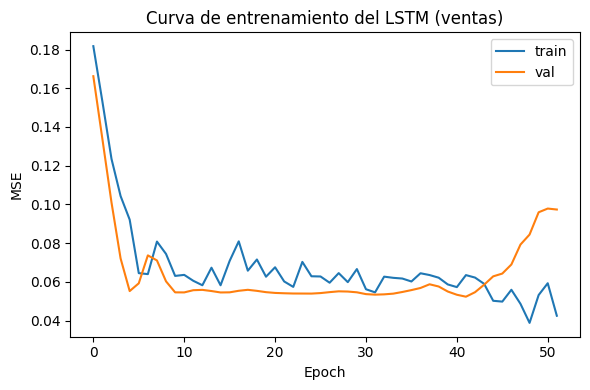

In [8]:
plt.figure(figsize=(6,4))
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Curva de entrenamiento del LSTM (ventas)')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluación del conjunto de prueba

Loss (MSE) en test (escala normalizada): 0.0893


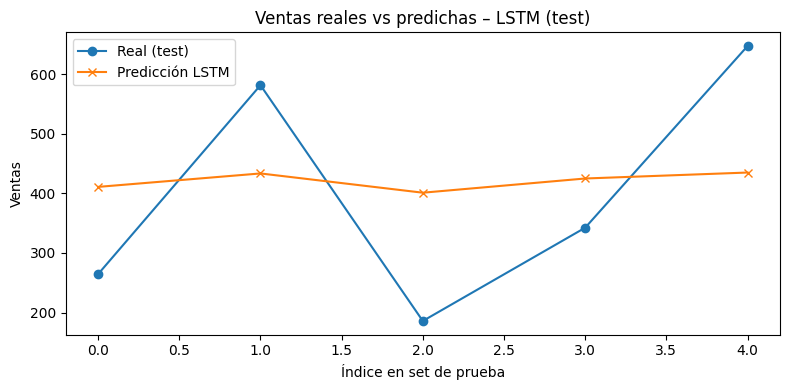

In [9]:
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss (MSE) en test (escala normalizada): {test_loss:.4f}")

y_test_pred = model.predict(X_test, verbose=0)
y_test_inv = scaler.inverse_transform(y_test)
y_test_pred_inv = scaler.inverse_transform(y_test_pred)

plt.figure(figsize=(8,4))
plt.plot(y_test_inv, label="Real (test)", marker="o")
plt.plot(y_test_pred_inv, label="Predicción LSTM", marker="x")
plt.xlabel("Índice en set de prueba")
plt.ylabel("Ventas")
plt.title("Ventas reales vs predichas – LSTM (test)")
plt.legend()
plt.tight_layout()
plt.show()

# SHAP

In [10]:
import shap
print("SHAP:", shap.__version__)

shap.initjs()


rng = np.random.default_rng(42)

# Subconjunto de prueba a explicar
n_explain = min(40, X_test.shape[0])
X_test_sample = X_test[:n_explain]

# Background para SHAP
n_bg = min(50, X_train.shape[0])
idx_bg = rng.choice(X_train.shape[0], size=n_bg, replace=False)
background = X_train[idx_bg]

print("Background:", background.shape)
print("X_test_sample:", X_test_sample.shape)

SHAP: 0.50.0


Background: (19, 12, 1)
X_test_sample: (5, 12, 1)


In [11]:
background_flat = background.reshape(background.shape[0], -1)
X_test_flat = X_test_sample.reshape(X_test_sample.shape[0], -1)

t_steps = window_size
n_feat = num_features
print("background_flat:", background_flat.shape)
print("X_test_flat:", X_test_flat.shape)


background_flat: (19, 12)
X_test_flat: (5, 12)


# Función modelo para KernelExplainer

In [12]:
def f(x):
    x_reshaped = x.reshape((-1, t_steps, n_feat))
    preds = model.predict(x_reshaped, verbose=0)
    return preds.ravel()

explainer = shap.KernelExplainer(f, background_flat)

shap_flat = explainer.shap_values(X_test_flat)

if isinstance(shap_flat, list):
    shap_flat = shap_flat[0]

print("shap_flat:", np.array(shap_flat).shape)

shap_ts = np.array(shap_flat).reshape(X_test_sample.shape[0], t_steps, n_feat)
print("shap_ts:", shap_ts.shape)

  0%|          | 0/5 [00:00<?, ?it/s]

shap_flat: (5, 12)
shap_ts: (5, 12, 1)


# Importancia media por paso temporal

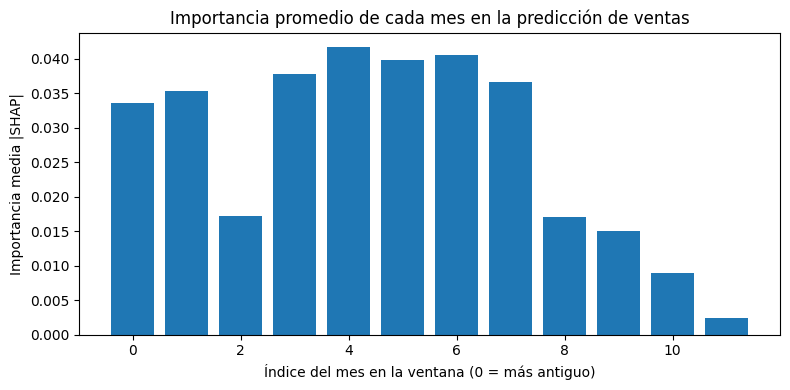

In [14]:
mean_abs_shap = np.mean(np.abs(shap_ts), axis=(0, 2))

plt.figure(figsize=(8,4))
plt.bar(range(t_steps), mean_abs_shap)
plt.xlabel('Índice del mes en la ventana (0 = más antiguo)')
plt.ylabel('Importancia media |SHAP|')
plt.title('Importancia promedio de cada mes en la predicción de ventas')
plt.tight_layout()
plt.show()

# Ejemplo Individual

Predicción LSTM (ventas) para ejemplo 1: 433.31 unidades


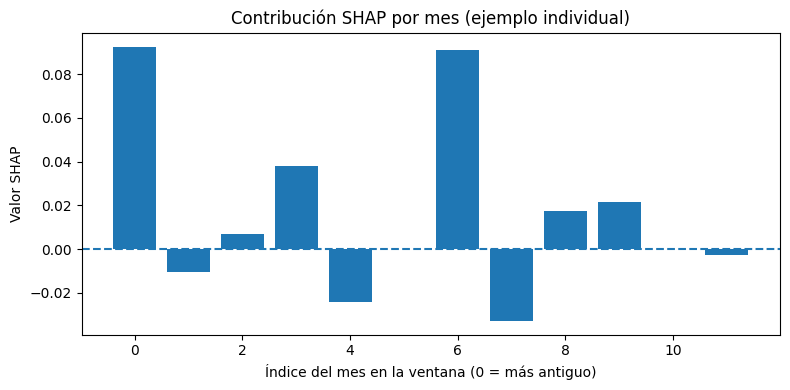

In [15]:
ejemplo_idx = 1

ejemplo = X_test_sample[ejemplo_idx:ejemplo_idx+1]

pred_ejemplo = model.predict(ejemplo, verbose=0)[0, 0]
pred_ejemplo_inv = scaler.inverse_transform([[pred_ejemplo]])[0, 0]

print(f"Predicción LSTM (ventas) para ejemplo {ejemplo_idx}: {pred_ejemplo_inv:.2f} unidades")

shap_ejemplo = shap_ts[ejemplo_idx]

contrib_por_mes = shap_ejemplo.mean(axis=1)

plt.figure(figsize=(8,4))
plt.bar(range(t_steps), contrib_por_mes)
plt.axhline(0, linestyle='--')
plt.xlabel('Índice del mes en la ventana (0 = más antiguo)')
plt.ylabel('Valor SHAP')
plt.title('Contribución SHAP por mes (ejemplo individual)')
plt.tight_layout()
plt.show()

# Summary plot de shap

/tmp/ipython-input-3680905124.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


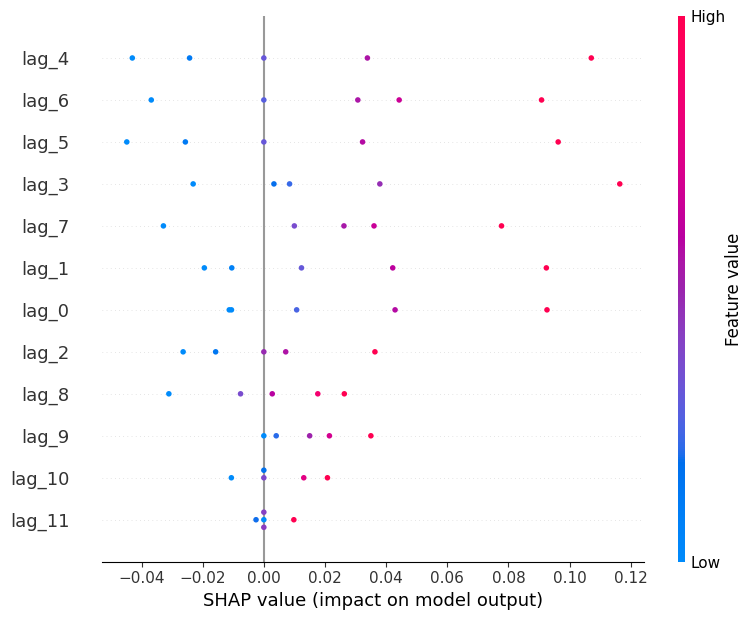

In [16]:
n_samples = shap_ts.shape[0]
shap_flat_all = shap_ts.reshape(n_samples, t_steps * n_feat)
X_flat_all = X_test_sample.reshape(n_samples, t_steps * n_feat)

feature_names = [f'lag_{i}' for i in range(t_steps * n_feat)]

shap.summary_plot(
    shap_flat_all,
    X_flat_all,
    feature_names=feature_names,
    show=False
)